# Tutorial Explanation
In this tutorial, we will cover the following key concepts and steps:

1. **Introduction to the Problem**: We will start by understanding the problem we aim to solve. This includes defining the objectives and the expected outcomes.

2. **Nanoparticle Creation and Training Set Generation**: We will create nanoparticles using the `Nanoparticle` class and generate a training set of nanoparticles with specific stoichiometry using the `create_octahedron_training_set` function.

3. **Feature Extraction**: We will extract topological features from the nanoparticles using the `TopologicalFeatureClassifier` class.

4. **Model Training**: We will train a Bayesian Ridge Regression model using the extracted features and the `BayesianRRCalculator` class.

5. **Model Evaluation**: We will evaluate the model by examining the coefficients of the trained model and visualizing them using Matplotlib.

6. **Model Saving**: We will save the trained model to a file for future use.

Throughout this tutorial, we will use Python and popular libraries such as NumPy and Matplotlib. Each step will be accompanied by code examples and explanations to ensure a clear understanding of the concepts and processes involved.

Let's get started!


In [1]:
from npl.core import Nanoparticle
from npl.calculators import EMTCalculator

def create_octahedron_training_set(n_particles, height, trunc, stoichiometry):
    emt_calculator = EMTCalculator(fmax=0.2, steps=1000)
    
    training_set = []
    for i in range(n_particles):
        p = Nanoparticle()
        p.truncated_octahedron(height, trunc, stoichiometry)
        emt_calculator.compute_energy(p)
        training_set.append(p)
        
    return training_set

In [2]:
"""Create one randomly ordered start particle"""

def create_start_particle(height, trunc, stoichiometry):
    start_particle = Nanoparticle()
    start_particle.truncated_octahedron(height, trunc, stoichiometry)
    return start_particle

In [3]:
"""Create the training set with 30 particles"""
stoichiometry={'Pt' : 55, 'Au' : 24}

training_set = create_octahedron_training_set(40, 5, 1, stoichiometry)

In [4]:
from npl.descriptors.global_feature_classifier import testTopologicalFeatureClassifier

classifier = testTopologicalFeatureClassifier(list(stoichiometry.keys()))

for p in training_set:
    classifier.compute_feature_vector(p)

In [5]:
from npl.calculators import BayesianRRCalculator

"""Create the calculator"""
calculator = BayesianRRCalculator(classifier.get_feature_key())
calculator.fit(training_set, 'EMT', validation_set=0.1)

Mean Absolute error 0.2889 eV
Root Mean Square error 0.3507 eV


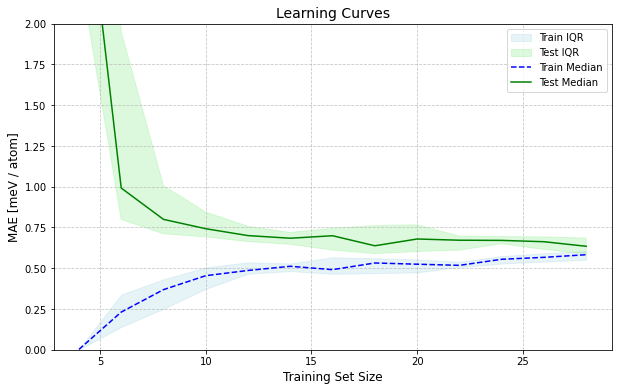

In [6]:
from npl.utils.utils import plot_learning_curves

X = [p.get_feature_vector('TFC') for p in training_set]
y = [p.get_energy('EMT') for p in training_set]
n_atoms = p.get_n_atoms()

plot_learning_curves(X, y, n_atoms,
                     calculator.ridge, 
                     n_splits = 10, 
                     train_sizes = range(4,30,2),
                     y_lim=(0,2),
                     filename='/home/riccardo/bin/repos/NPlib/docs/images/learning_curve.png')

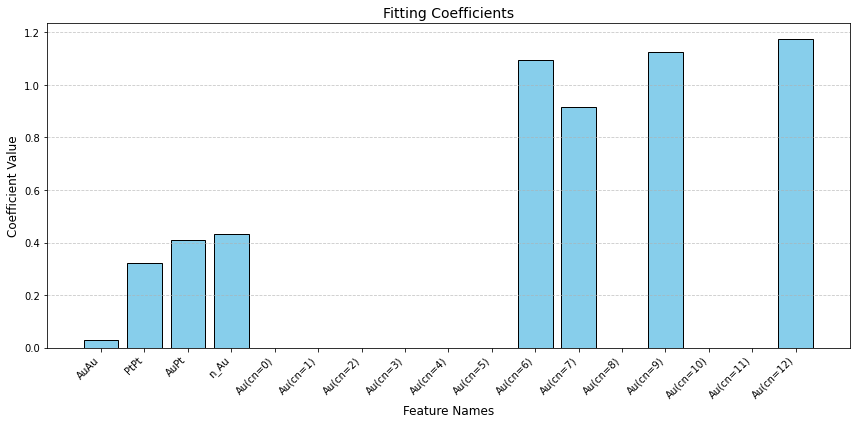

<Figure size 432x288 with 0 Axes>

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Get the coefficients from the calculator
coefficients = calculator.get_coefficients()
# Get the feature names from the classifier
feature_names = classifier.get_feature_labels()

# Plotting the coefficients with feature names as x labels
plt.figure(figsize=(12, 6))  # Set figure size for better visibility
plt.bar(range(len(coefficients)), coefficients, color='skyblue', edgecolor='black')
plt.axhline(0, color='gray', linestyle='--', linewidth=1)  # Improved horizontal line for zero reference

# Set x-ticks with feature names and rotate for clarity
plt.xticks(range(len(coefficients)), feature_names, rotation=45, ha='right', fontsize=10)
plt.xlabel('Feature Names', fontsize=12)  # Improved label
plt.ylabel('Coefficient Value', fontsize=12)
plt.title('Fitting Coefficients', fontsize=14)  # Increased title font size
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Added grid for better readability

plt.tight_layout()  # Adjust layout to make room for rotated labels
plt.show()
plt.savefig('/home/riccardo/bin/repos/NPlib/docs/images/coefficients.png', dpi=200)


In [8]:
import pickle

# Save the BayesianRRCalculator object to a file
calculator.save('bayesian_rr_calculator.pkl')